## CASE 1: Predict Stock Price Movement Using News Headlines

Import bunch of packages:

In [ ]:
import numpy as np 
import pandas as pd 
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import re
from wordcloud import WordCloud,STOPWORDS
import nltk
from nltk.corpus import stopwords
import matplotlib
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
import np_utils
import tensorflow.keras.utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Lambda
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM, SimpleRNN, GRU
from tensorflow.keras.layers import Convolution1D
from tensorflow.keras import backend as K
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import sklearn.metrics 
import seaborn as sns
import gensim.parsing.preprocessing as gsp
from gensim import utils

Define functions that can preprocess texts：

In [3]:
def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s

Combine all headlines and shuffle the data:

In [4]:
data = pd.read_csv(r'C:\Users\Yueru\Desktop\UMD\summer 2020\MIT\129_792900_bundle_archive\Combined_News_DJIA.csv')
data['Combined']=data.iloc[:,2:27].apply(lambda row: ''.join(str(row.values)), axis=1)
train,test=train_test_split(data,test_size=0.15,random_state=42)

Data preprocessing:

In [5]:
# Removing punctuations
slicedData= train.iloc[:,2:27]
slicedData.replace(to_replace="[^a-zA-Z]", value=" ", regex=True, inplace=True)
# Renaming column names for ease of access
list1= [i for i in range(25)]
new_Index=[str(i) for i in list1]
slicedData.columns= new_Index
slicedData.head(5)
# Convertng headlines to lower case
for index in new_Index:
    slicedData[index]=slicedData[index].str.lower()
# Removing punctuations
slicedData= train.iloc[:,2:27]
slicedData.replace(to_replace="[^a-zA-Z]", value=" ", regex=True, inplace=True)
# Renaming column names for ease of access
list1= [i for i in range(25)]
new_Index=[str(i) for i in list1]
slicedData.columns= new_Index
slicedData.head(5)
# Convertng headlines to lower case
for index in new_Index:
    slicedData[index]=slicedData[index].str.lower()
newdf = shuffle(slicedData)
# combine all headlines
trainheadlines = []
for row in range(0,len(slicedData.index)):
    trainheadlines.append(' '.join(str(x) for x in slicedData.iloc[row,0:25]))
basicvectorizer = CountVectorizer(ngram_range=(2,2))
basictrain = basicvectorizer.fit_transform(trainheadlines)

Create Word Cloud to see the weights of words/phrases:

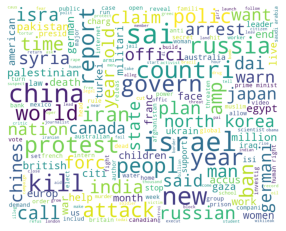

In [10]:
filters = [
           gsp.strip_tags, 
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords, 
           gsp.strip_short, 
           gsp.stem_text
          ]
result=clean_text(" ".join(trainheadlines))
wc = WordCloud(
        # setup font and background color
        background_color='white',
        # setup background height and width
        width=1000,
        height=800,
        # setup maximum and minimum font sizes
        max_font_size=100,
        min_font_size=5,
        mode='RGBA'
        )
wc.generate(result)
plt.figure("jay")
plt.imshow(wc)
plt.axis("off")
plt.show()

Explore Naive Bayes first, and found out that 2-gram NB has higher accuracy than 1-gram (i.e. single word) NB. Therefore here I use 2-gram NB, but got a pretty low accuracy of 47%:

NBayes 2 accuracy:  0.47157190635451507


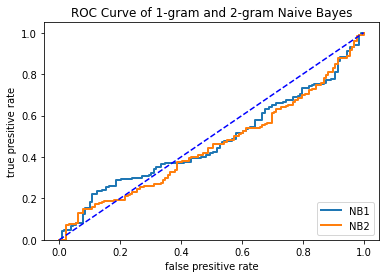

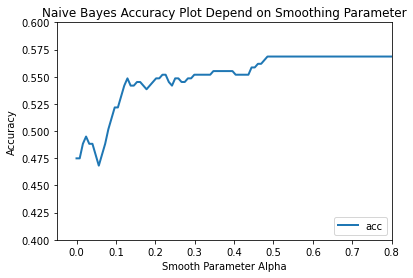

In [26]:
######### NB 1-gram  #############
advancedvectorizer = TfidfVectorizer(ngram_range = (1, 1))
advancedtrain = advancedvectorizer.fit_transform(trainheadlines)

advancedmode2 = MultinomialNB(alpha=0.01)
advancedmode2 = advancedmode2.fit(advancedtrain, train["Label"])
testheadlines = []
for row in range(0,len(test.index)):
    testheadlines.append(' '.join(str(x) for x in test.iloc[row,2:27]))
advancedtest = advancedvectorizer.transform(testheadlines)
preds1 = advancedmode2.predict(advancedtest)

acc1=accuracy_score(test['Label'], preds1)

y_prob=advancedmode2.predict_proba(advancedtest)[:,1]
fpr1, tpr1, thresholds=sklearn.metrics.roc_curve(test['Label'],y_prob,pos_label=1,sample_weight=None,drop_intermediate=True)

######### NB 2-gram  #############
advancedvectorizer = TfidfVectorizer(ngram_range = (2, 2))
advancedtrain = advancedvectorizer.fit_transform(trainheadlines)

advancedmodel = MultinomialNB(alpha=0.0001)
advancedmodel = advancedmodel.fit(advancedtrain, train["Label"])
testheadlines = []
for row in range(0,len(test.index)):
    testheadlines.append(' '.join(str(x) for x in test.iloc[row,2:27]))
advancedtest = advancedvectorizer.transform(testheadlines)
preds2 = advancedmodel.predict(advancedtest)
acc2 = accuracy_score(test['Label'], preds2)
print('NBayes 2 accuracy: ', acc2)
y_prob=advancedmodel.predict_proba(advancedtest)[:,1]
fpr2, tpr2, thresholds=sklearn.metrics.roc_curve(test['Label'],y_prob,pos_label=1,sample_weight=None,drop_intermediate=True)
plt.plot(fpr1,tpr1,linewidth=2,label="NB1")
plt.plot(fpr2,tpr2,linewidth=2,label="NB2")
plt.title("ROC Curve of 1-gram and 2-gram Naive Bayes")
plt.xlabel("false presitive rate")
plt.ylabel("true presitive rate")
plt.ylim(0,1.05)
plt.xlim(-0.05,1.05)
plt.plot([0,1],[0,1], c='b',linestyle='--')
plt.legend(loc=4)
test_auc = sklearn.metrics.roc_auc_score(test['Label'],y_prob)
plt.show()
##NB2-ALPHA
accs=[]
aps=np.linspace(0.000001,0.8,100)
for i in aps:
    
    advancedmodel = MultinomialNB(alpha=i)
    advancedmodel = advancedmodel.fit(advancedtrain, train["Label"])
    testheadlines = []
    for row in range(0,len(test.index)):
        testheadlines.append(' '.join(str(x) for x in test.iloc[row,2:27]))
    advancedtest = advancedvectorizer.transform(testheadlines)
    preds5 = advancedmodel.predict(advancedtest)
    accs.append(accuracy_score(test['Label'], preds5))
plt.plot(aps,accs,linewidth=2,label="acc")
plt.title("Naive Bayes Accuracy Plot Depend on Smoothing Parameter")
plt.xlabel("Smooth Parameter Alpha")
plt.ylabel("Accuracy")
plt.ylim(0.4,0.6)
plt.xlim(-0.05,0.8)
plt.legend(loc=4)
plt.show()

Use LSTM next, and get an accuracy of 52%:

Epoch 1/3
53/53 [==============================] - 8s 143ms/step - loss: 0.6918 - accuracy: 0.5278 - val_loss: 0.6898 - val_accuracy: 0.5753
Epoch 2/3
53/53 [==============================] - 7s 131ms/step - loss: 0.6204 - accuracy: 0.6763 - val_loss: 0.7467 - val_accuracy: 0.4950
Epoch 3/3
10/10 [==============================] - 0s 31ms/step - loss: 0.9679 - accuracy: 0.5217
Test accuracy: 0.52173912525177
prediction accuracy:  0.5217391304347826


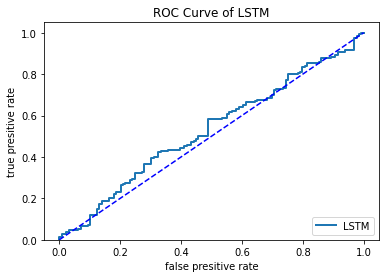

In [27]:
testheadlines = []
for row in range(0,len(test.index)):
    testheadlines.append(' '.join(str(x) for x in test.iloc[row,2:27]))
max_features = 10000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.1
maxlen = 200
batch_size = 32
nb_classes = 2
# vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(trainheadlines)
sequences_train = tokenizer.texts_to_sequences(trainheadlines)
sequences_test = tokenizer.texts_to_sequences(testheadlines)
X_train = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test = sequence.pad_sequences(sequences_test, maxlen=maxlen)

y_train = np.array(train["Label"])
y_test = np.array(test["Label"])

Y_train = tensorflow.keras.utils.to_categorical(y_train, nb_classes)
Y_test = tensorflow.keras.utils.to_categorical(y_test, nb_classes)

model = Sequential()
model.add(Embedding(max_features, 128))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=batch_size, epochs=3,
          validation_data=(X_test, Y_test))
score, acc = model.evaluate(X_test, Y_test,
                            batch_size=batch_size)
print('Test accuracy:', acc)

preds3 = model.predict_classes(X_test, verbose=0)
acc3 = accuracy_score(test['Label'], preds3)
print('prediction accuracy: ', acc3)
y_prob=model.predict(X_test)[:,1]
fpr, tpr, thresholds=sklearn.metrics.roc_curve(test['Label'],y_prob,pos_label=1,sample_weight=None,drop_intermediate=True)
plt.plot(fpr,tpr,linewidth=2,label="LSTM")
plt.title("ROC Curve of LSTM")
plt.xlabel("false presitive rate")
plt.ylabel("true presitive rate")
plt.ylim(0,1.05)
plt.xlim(-0.05,1.05)
plt.plot([0,1],[0,1], c='b',linestyle='--')
plt.legend(loc=4)
test_auc = sklearn.metrics.roc_auc_score(test['Label'],y_prob)
plt.show()

Use Convolutional Neural Network (CNN), and achieves the highest accuracy of 57% among the 3 algorithms:

10/10 [==============================] - 0s 9ms/step - loss: 0.6917 - accuracy: 0.5686
Test accuracy: 0.568561851978302
prediction accuracy:  0.568561872909699


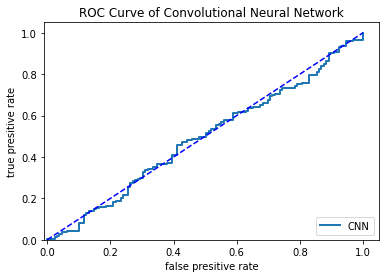

In [28]:
testheadlines = []
for row in range(0,len(test.index)):
    testheadlines.append(' '.join(str(x) for x in test.iloc[row,2:27]))
nb_filter = 500
filter_length = 2
hidden_dims = 120
nb_epoch = 2

model = Sequential()
model.add(Embedding(max_features, 128))
model.add(Dropout(0.2))
# Add a Convolution1D, which will learn nb_filter
# word group filters of size filter_length:
model.add(Convolution1D(filters=nb_filter,kernel_size=filter_length,padding='valid',activation='relu'))

def max_1d(X):
    return K.max(X, axis=1)

model.add(Lambda(max_1d, output_shape=(nb_filter,)))
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(nb_classes))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=32, epochs=1,
          validation_data=(X_test, Y_test))
score, acc = model.evaluate(X_test, Y_test,
                            batch_size=batch_size)

print('Test accuracy:', acc)

preds4 = model.predict_classes(X_test, verbose=0)
acc4 = accuracy_score(test['Label'], preds4)

print('prediction accuracy: ', acc4)
y_prob=model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds=sklearn.metrics.roc_curve(test['Label'],y_prob,pos_label=1,sample_weight=None,drop_intermediate=True)
plt.plot(fpr,tpr,linewidth=2,label="CNN")
plt.title("ROC Curve of Convolutional Neural Network")
plt.xlabel("false presitive rate")
plt.ylabel("true presitive rate")
plt.ylim(0,1.05)
plt.xlim(-0.01,1.05)
plt.plot([0,1],[0,1], c='b',linestyle='--')
plt.legend(loc=4)
test_auc = sklearn.metrics.roc_auc_score(test['Label'],y_prob)
plt.show()